<a href="https://colab.research.google.com/github/BRIDEBENSON/NOVA---Navigational-Object-Verification-and-Alignment/blob/main/offset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stars detected (pixel coordinates):
Star 1: (74, 293)
Star 2: (123, 23)
Star 3: (125, 277)
Star 4: (140, 243)
Star 5: (144, 334)
Star 6: (156, 245)
Star 7: (171, 246)
Star 8: (184, 12)
Star 9: (190, 151)
Star 10: (241, 213)
Star 11: (255, 171)
Star 12: (271, 1)
Star 13: (290, 16)
Star 14: (347, 95)


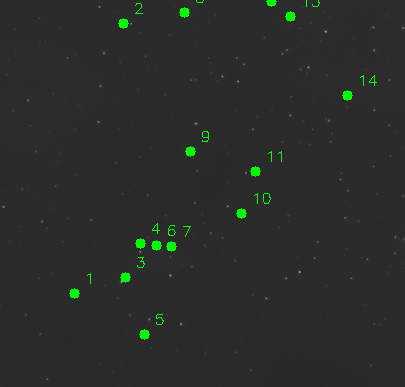

In [8]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Step 1: Upload image
def upload_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    return image

# Step 2: Set threshold and find pixel coordinates corresponding to stars
def find_stars(image, threshold):
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    stars = []
    for contour in contours:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            stars.append((cx, cy))
    return sorted(stars, key=lambda star: (star[0], star[1]))

# Step 3: Display image with stars numbered
def display_image_with_numbers(image, stars):
    display_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for i, (x, y) in enumerate(stars):
        cv2.circle(display_image, (x, y), 5, (0, 255, 0), -1)
        cv2.putText(display_image, f"{i + 1}", (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    cv2_imshow(display_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Main workflow
def main():
    # Input image path
    image_path = "/content/orion.jpg"  # Replace with the actual image path
    image = upload_image(image_path)

    # Set threshold to recognize stars
    threshold = 105  # Adjust as needed
    stars = find_stars(image, threshold)
    print("Stars detected (pixel coordinates):")
    for i, star in enumerate(stars):
        print(f"Star {i + 1}: {star}")

    # Display image with stars numbered
    display_image_with_numbers(image, stars)

if __name__ == "__main__":
    main()

In [2]:
import math

def hms_to_deg(h, m, s):
    return (h + m/60 + s/3600) * 15

def dms_to_deg(d, m, s):
    sign = -1 if d < 0 else 1
    return sign * (abs(d) + m/60 + s/3600)

def deg_to_hms(deg):
    deg = deg % 360
    h = int(deg / 15)
    remainder = (deg / 15 - h) * 60
    m = int(remainder)
    s = (remainder - m) * 60
    return h, m, s

def deg_to_dms(deg):
    sign = "-" if deg < 0 else "+"
    deg = abs(deg)
    d = int(deg)
    remainder = (deg - d) * 60
    m = int(remainder)
    s = (remainder - m) * 60
    return sign + str(d), m, s

def calculate_reticle_radec(x1, y1, ra1_h, ra1_m, ra1_s, dec1_d, dec1_m, dec1_s,
                          x2, y2, ra2_h, ra2_m, ra2_s, dec2_d, dec2_m, dec2_s,
                          x_reticle, y_reticle, pa=0):
    """Calculate RA/Dec for a reticle position using linear transformation"""
    try:
        # Convert coordinates to decimal degrees
        ra1 = hms_to_deg(ra1_h, ra1_m, ra1_s)
        dec1 = dms_to_deg(dec1_d, dec1_m, dec1_s)
        ra2 = hms_to_deg(ra2_h, ra2_m, ra2_s)
        dec2 = dms_to_deg(dec2_d, dec2_m, dec2_s)

        # Calculate differences in both coordinate systems
        dx = x2 - x1
        dy = y2 - y1
        dra = (ra2 - ra1) * math.cos(math.radians((dec1 + dec2) / 2))  # Scale RA difference by cos(dec)
        ddec = dec2 - dec1

        # Calculate scale factors and rotation
        pixel_dist = math.sqrt(dx**2 + dy**2)
        sky_dist = math.sqrt(dra**2 + ddec**2)
        scale = sky_dist / pixel_dist

        # Calculate rotation angle
        theta = math.atan2(ddec, dra) - math.atan2(dy, dx) - math.radians(pa)

        # Calculate reticle offset from first reference star
        dx_reticle = x_reticle - x1
        dy_reticle = y_reticle - y1

        # Apply rotation and scale to get sky coordinate offsets
        dra_reticle = scale * (dx_reticle * math.cos(theta) - dy_reticle * math.sin(theta))
        ddec_reticle = scale * (dx_reticle * math.sin(theta) + dy_reticle * math.cos(theta))

        # Apply offsets to get final coordinates
        # Adjust RA offset for cos(dec) scaling
        ra_reticle = ra1 + dra_reticle / math.cos(math.radians(dec1 + ddec_reticle/2))
        dec_reticle = dec1 + ddec_reticle

        return ra_reticle % 360, dec_reticle

    except Exception as e:
        print(f"Error in calculation: {e}")
        return None, None

def test_coordinates(test_num, x1, y1, ra1_h, ra1_m, ra1_s, dec1_d, dec1_m, dec1_s,
                    x2, y2, ra2_h, ra2_m, ra2_s, dec2_d, dec2_m, dec2_s,
                    x_reticle, y_reticle, expected_ra=None, expected_dec=None, pa=0):
    print(f"\nTest Case {test_num}:")
    print(f"Reference 1: ({x1}, {y1}) -> RA: {ra1_h}h {ra1_m}m {ra1_s}s, Dec: {dec1_d}° {dec1_m}' {dec1_s}\"")
    print(f"Reference 2: ({x2}, {y2}) -> RA: {ra2_h}h {ra2_m}m {ra2_s}s, Dec: {dec2_d}° {dec2_m}' {dec2_s}\"")
    print(f"Reticle: ({x_reticle}, {y_reticle})")

    reticle_ra, reticle_dec = calculate_reticle_radec(
        x1, y1, ra1_h, ra1_m, ra1_s, dec1_d, dec1_m, dec1_s,
        x2, y2, ra2_h, ra2_m, ra2_s, dec2_d, dec2_m, dec2_s,
        x_reticle, y_reticle, pa
    )

    if reticle_ra is not None:
        ra_h, ra_m, ra_s = deg_to_hms(reticle_ra)
        dec_d, dec_m, dec_s = deg_to_dms(reticle_dec)
        print(f"Calculated: RA = {ra_h}h {ra_m}m {ra_s:.3f}s, Dec = {dec_d}° {dec_m}' {dec_s:.3f}\"")

        if expected_ra is not None:
            exp_ra = hms_to_deg(expected_ra[0], expected_ra[1], expected_ra[2])
            exp_dec = dms_to_deg(expected_dec[0], expected_dec[1], expected_dec[2])
            ra_diff = abs(reticle_ra - exp_ra)
            if ra_diff > 180:
                ra_diff = 360 - ra_diff
            dec_diff = abs(reticle_dec - exp_dec)
            print(f"Expected:   RA = {expected_ra[0]}h {expected_ra[1]}m {expected_ra[2]}s, Dec = {expected_dec[0]}° {expected_dec[1]}' {expected_dec[2]}\"")
            print(f"Difference: RA = {ra_diff:.4f}°, Dec = {dec_diff:.4f}°")

# Run test cases
print("Testing with PA = 0°...")

# Test Case 1
test_coordinates(1,
    190, 151, 5, 56, 32.8, 7, 24, 43.5,  # First reference star
    144, 333, 5, 15, 45.7, -8, 10, 20.4,  # Second reference star
    242, 214,  # Reticle position
    expected_ra=(5, 26, 29.6),  # Expected RA
    expected_dec=(6, 22, 21.9),  # Expected Dec
    pa=0
)

# Test Case 2
test_coordinates(2,
    190, 151, 5, 56, 32.8, 7, 24, 43.5,  # First reference star
    242, 214, 5, 26, 29.6, 6, 22, 21.9,  # Second reference star
    144, 333,  # Reticle position
    expected_ra=(5, 15, 45.7),  # Expected RA
    expected_dec=(-8, 10, 20.4),  # Expected Dec
    pa=0
)

Testing with PA = 0°...

Test Case 1:
Reference 1: (190, 151) -> RA: 5h 56m 32.8s, Dec: 7° 24' 43.5"
Reference 2: (144, 333) -> RA: 5h 15m 45.7s, Dec: -8° 10' 20.4"
Reticle: (242, 214)
Calculated: RA = 5h 23m 55.233s, Dec = +6° 58' 33.380"
Expected:   RA = 5h 26m 29.6s, Dec = 6° 22' 21.9"
Difference: RA = 0.6432°, Dec = 0.6032°

Test Case 2:
Reference 1: (190, 151) -> RA: 5h 56m 32.8s, Dec: 7° 24' 43.5"
Reference 2: (242, 214) -> RA: 5h 26m 29.6s, Dec: 6° 22' 21.9"
Reticle: (144, 333)
Calculated: RA = 5h 23m 40.599s, Dec = -7° 49' 9.747"
Expected:   RA = 5h 15m 45.7s, Dec = -8° 10' 20.4"
Difference: RA = 1.9787°, Dec = 0.3530°


In [ ]:
import math

def calculate_offset(current_ra_h, current_ra_m, current_ra_s, current_dec_d, current_dec_m, current_dec_s,
                    target_ra_h, target_ra_m, target_ra_s, target_dec_d, target_dec_m, target_dec_s):
    """
    Calculate the offset from current position to target position in degrees.
    Returns the offset in RA and Dec, accounting for spherical distortion.

    Parameters:
    current_ra_h/m/s: Current RA in hours, minutes, seconds
    current_dec_d/m/s: Current Dec in degrees, minutes, seconds
    target_ra_h/m/s: Target RA in hours, minutes, seconds
    target_dec_d/m/s: Target Dec in degrees, minutes, seconds

    Returns:
    tuple: (RA_offset, Dec_offset) in degrees
    """
    # Convert everything to decimal degrees
    current_ra = (current_ra_h + current_ra_m/60 + current_ra_s/3600) * 15
    current_dec = current_dec_d + current_dec_m/60 + current_dec_s/3600
    target_ra = (target_ra_h + target_ra_m/60 + target_ra_s/3600) * 15
    target_dec = target_dec_d + target_dec_m/60 + target_dec_s/3600

    # Calculate RA difference, handling wraparound at 360 degrees
    ra_diff = target_ra - current_ra
    if ra_diff > 180:
        ra_diff -= 360
    elif ra_diff < -180:
        ra_diff += 360

    # Scale RA difference by cos(dec) to account for spherical distortion
    # Use the average declination for the scaling
    avg_dec = math.radians((current_dec + target_dec) / 2)
    ra_offset = ra_diff * math.cos(avg_dec)

    # Calculate Dec difference
    dec_offset = target_dec - current_dec

    # Calculate true angular separation (optional, but useful for verification)
    angular_sep = math.degrees(math.acos(
        math.sin(math.radians(current_dec)) * math.sin(math.radians(target_dec)) +
        math.cos(math.radians(current_dec)) * math.cos(math.radians(target_dec)) *
        math.cos(math.radians(ra_diff))
    ))

    return {
        'ra_offset': ra_offset,  # degrees, negative means move west
        'dec_offset': dec_offset,  # degrees, negative means move south
        'angular_separation': angular_sep,  # degrees
        'ra_offset_time': ra_diff/15,  # hours
        'dec_offset_arcmin': dec_offset * 60  # arcminutes
    }

# Example usage:
def test_offset():
    # Example: Calculate offset from current position to target
    result = calculate_offset(
        current_ra_h=5, current_ra_m=26, current_ra_s=32.8,  # Current RA
        current_dec_d=7, current_dec_m=24, current_dec_s=43.5,  # Current Dec
        target_ra_h=6, target_ra_m=46, target_ra_s=16.5,  # Target RA
        target_dec_d=-16, target_dec_m=45, target_dec_s=2.6  # Target Dec
    )

    print(f"Offset to target:")
    print(f"RA offset: {result['ra_offset']:.4f}° ({result['ra_offset_time']*60:.1f} minutes of time)")
    print(f"Dec offset: {result['dec_offset']:.4f}° ({result['dec_offset_arcmin']:.1f} arcminutes)")
    print(f"Angular separation: {result['angular_separation']:.4f}°")

if __name__ == "__main__":
    test_offset()

Offset to target:
RA offset: 19.8855° (79.7 minutes of time)
Dec offset: -22.6614° (-1359.7 arcminutes)
Angular separation: 30.0616°


In [ ]:
import math

# Utility functions for coordinate conversions
def hms_to_deg(h, m, s):
    """Convert hours, minutes, seconds to decimal degrees"""
    return (h + m/60 + s/3600) * 15

def dms_to_deg(d, m, s):
    """Convert degrees, minutes, seconds to decimal degrees"""
    sign = -1 if d < 0 else 1
    return sign * (abs(d) + m/60 + s/3600)

def deg_to_hms(deg):
    """Convert decimal degrees to hours, minutes, seconds"""
    deg = deg % 360
    h = int(deg / 15)
    remainder = (deg / 15 - h) * 60
    m = int(remainder)
    s = (remainder - m) * 60
    return h, m, s

def deg_to_dms(deg):
    """Convert decimal degrees to degrees, minutes, seconds with sign"""
    sign = "-" if deg < 0 else 1
    deg = abs(deg)
    d = int(deg)
    remainder = (deg - d) * 60
    m = int(remainder)
    s = (remainder - m) * 60
    return sign * d, m, s  # Changed to return numeric value for sign

def calculate_reticle_radec(x1, y1, ra1_h, ra1_m, ra1_s, dec1_d, dec1_m, dec1_s,
                          x2, y2, ra2_h, ra2_m, ra2_s, dec2_d, dec2_m, dec2_s,
                          x_reticle, y_reticle, pa=0):
    """Calculate RA/Dec for a reticle position using linear transformation"""
    try:
        # Convert coordinates to decimal degrees
        ra1 = hms_to_deg(ra1_h, ra1_m, ra1_s)
        dec1 = dms_to_deg(dec1_d, dec1_m, dec1_s)
        ra2 = hms_to_deg(ra2_h, ra2_m, ra2_s)
        dec2 = dms_to_deg(dec2_d, dec2_m, dec2_s)

        # Calculate differences in both coordinate systems
        dx = x2 - x1
        dy = y2 - y1
        dra = (ra2 - ra1) * math.cos(math.radians((dec1 + dec2) / 2))  # Scale RA difference by cos(dec)
        ddec = dec2 - dec1

        # Calculate scale factors and rotation
        pixel_dist = math.sqrt(dx**2 + dy**2)
        sky_dist = math.sqrt(dra**2 + ddec**2)
        scale = sky_dist / pixel_dist

        # Calculate rotation angle
        theta = math.atan2(ddec, dra) - math.atan2(dy, dx) - math.radians(pa)

        # Calculate reticle offset from first reference star
        dx_reticle = x_reticle - x1
        dy_reticle = y_reticle - y1

        # Apply rotation and scale to get sky coordinate offsets
        dra_reticle = scale * (dx_reticle * math.cos(theta) - dy_reticle * math.sin(theta))
        ddec_reticle = scale * (dx_reticle * math.sin(theta) + dy_reticle * math.cos(theta))

        # Apply offsets to get final coordinates
        # Adjust RA offset for cos(dec) scaling
        ra_reticle = ra1 + dra_reticle / math.cos(math.radians(dec1 + ddec_reticle/2))
        dec_reticle = dec1 + ddec_reticle

        return ra_reticle % 360, dec_reticle

    except Exception as e:
        print(f"Error in calculation: {e}")
        return None, None

def calculate_offset(current_ra, current_dec, target_ra_h, target_ra_m, target_ra_s,
                    target_dec_d, target_dec_m, target_dec_s):
    """
    Calculate the offset from current position to target position in degrees.

    Parameters:
    current_ra: Current RA in decimal degrees
    current_dec: Current Dec in decimal degrees
    target_ra_h/m/s: Target RA in hours, minutes, seconds
    target_dec_d/m/s: Target Dec in degrees, minutes, seconds
    """
    # Convert target coordinates to decimal degrees
    target_ra = hms_to_deg(target_ra_h, target_ra_m, target_ra_s)
    target_dec = dms_to_deg(target_dec_d, target_dec_m, target_dec_s)

    # Calculate RA difference, handling wraparound at 360 degrees
    ra_diff = target_ra - current_ra
    if ra_diff > 180:
        ra_diff -= 360
    elif ra_diff < -180:
        ra_diff += 360

    # Scale RA difference by cos(dec) to account for spherical distortion
    avg_dec = math.radians((current_dec + target_dec) / 2)
    ra_offset = ra_diff * math.cos(avg_dec)

    # Calculate Dec difference
    dec_offset = target_dec - current_dec

    # Calculate true angular separation
    angular_sep = math.degrees(math.acos(
        math.sin(math.radians(current_dec)) * math.sin(math.radians(target_dec)) +
        math.cos(math.radians(current_dec)) * math.cos(math.radians(target_dec)) *
        math.cos(math.radians(ra_diff))
    ))

    return {
        'ra_offset': ra_offset,
        'dec_offset': dec_offset,
        'angular_separation': angular_sep,
        'ra_offset_time': ra_diff/15,
        'dec_offset_arcmin': dec_offset * 60
    }

def print_coordinates(name, ra_deg, dec_deg):
    """Helper function to print coordinates in both decimal degrees and HMS/DMS format"""
    ra_h, ra_m, ra_s = deg_to_hms(ra_deg)
    dec_d, dec_m, dec_s = deg_to_dms(dec_deg)
    print(f"{name}:")
    print(f"  RA: {ra_deg:.4f}° = {ra_h}h {ra_m}m {ra_s:.3f}s")
    print(f"  Dec: {dec_deg:.4f}° = {dec_d}° {dec_m}' {dec_s:.3f}\"")

def calculate_complete_solution(x1, y1, ra1_h, ra1_m, ra1_s, dec1_d, dec1_m, dec1_s,
                              x2, y2, ra2_h, ra2_m, ra2_s, dec2_d, dec2_m, dec2_s,
                              x_reticle, y_reticle,
                              target_ra_h, target_ra_m, target_ra_s,
                              target_dec_d, target_dec_m, target_dec_s,
                              pa=0):
    """Calculate both reticle position and offset to target"""

    # First calculate reticle position
    reticle_ra, reticle_dec = calculate_reticle_radec(
        x1, y1, ra1_h, ra1_m, ra1_s, dec1_d, dec1_m, dec1_s,
        x2, y2, ra2_h, ra2_m, ra2_s, dec2_d, dec2_m, dec2_s,
        x_reticle, y_reticle, pa
    )

    if reticle_ra is None or reticle_dec is None:
        return None

    # Calculate offset from reticle position to target
    offset_result = calculate_offset(
        reticle_ra, reticle_dec,
        target_ra_h, target_ra_m, target_ra_s,
        target_dec_d, target_dec_m, target_dec_s
    )

    return {
        'reticle_ra': reticle_ra,
        'reticle_dec': reticle_dec,
        'offset': offset_result
    }

def test_complete_solution():
    """Test the complete workflow with sample data"""
    print("\nTesting complete solution...")

    # Test case with sample data
    result = calculate_complete_solution(
        # Reference star 1
        190, 151, 5, 56, 32.8, 7, 24, 43.5,
        # Reference star 2
        144, 333, 5, 15, 45.7, -8, 10, 20.4,
        # Reticle position
        242, 214,
        # Target coordinates
        6, 46, 16.5,  # Target RA
        -16, 45, 2.6    # Target Dec
    )

    if result:
        print("\nCalculated Positions:")
        print_coordinates("Reticle position", result['reticle_ra'], result['reticle_dec'])

        print("\nOffset to target:")
        print(f"RA offset: {result['offset']['ra_offset']:.4f}° ({result['offset']['ra_offset_time']*60:.1f} minutes of time)")
        print(f"Dec offset: {result['offset']['dec_offset']:.4f}° ({result['offset']['dec_offset_arcmin']:.1f} arcminutes)")
        print(f"Angular separation: {result['offset']['angular_separation']:.4f}°")

if __name__ == "__main__":
    test_complete_solution()


Testing complete solution...

Calculated Positions:
Reticle position:
  RA: 80.9801° = 5h 23m 55.233s
  Dec: 6.9759° = 6° 58' 33.380"

Offset to target:
RA offset: 20.5138° (82.4 minutes of time)
Dec offset: -23.7267° (-1423.6 arcminutes)
Angular separation: 31.2659°
